<a href="https://colab.research.google.com/github/danoAasland/OhioUtilModel/blob/master/notebookModels/trainPredGas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#python 2/3 compatibility
from __future__ import absolute_import, division, print_function, unicode_literals
#packages
import pathlib
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
#add code to input data
#for now, uploads data file from local drive
dataset1 =  pd.read_csv('cinTargetClean.csv')
dataset2 =  pd.read_csv('cleTargetClean.csv')

In [0]:
#combine cleveland and cinncinati target datasets into one
dataset = pd.concat([dataset1, dataset2])

In [0]:
#drop client name column
dataset.drop('FullName', axis = 1, inplace = True)

In [0]:
#deleting the init. datasets now that they're one large dataset
del dataset1
del dataset2

In [0]:
#set home value at/above 100k
dataset = dataset[dataset['Value'] >= 100000.00].copy()

In [0]:
#set energy value above 6000 KwH Annual
dataset = dataset[dataset['E annual'] >= 6000.00].copy()

In [0]:
#set energy value less than 6000 KwH Annual
dataset = dataset[dataset['G annual'] <= 4000.00].copy()

In [0]:
#check to ensure dataset concat. correctly
#uncomment to run
#dataset.shape

In [0]:
dataset.columns.values

array(['SF', 'Floors', 'Year Built', 'Value', 'E annual', 'G annual'],
      dtype=object)

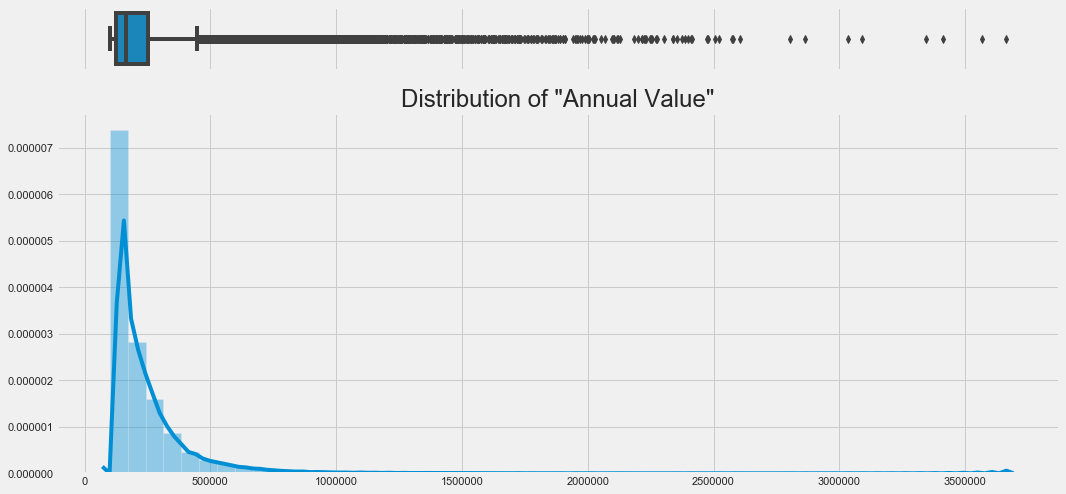

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#set style of graphs
sns.set(rc={'figure.figsize':(12, 6)})
plt.style.use('fivethirtyeight')

fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(dataset['Value'], ax=boxplot)
sns.distplot(dataset['Value'], ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution of "Annual Value"', fontsize=24)
plt.xlabel('');

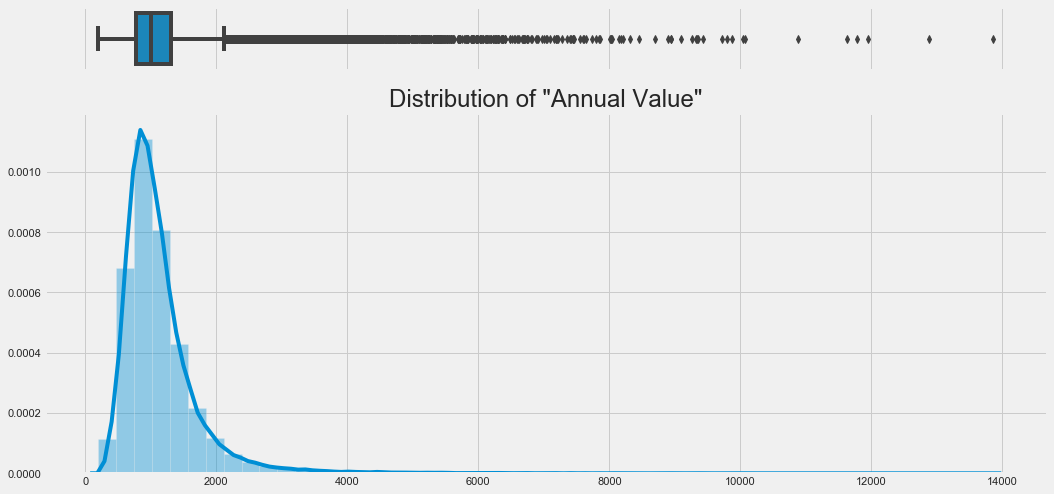

In [0]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(train_labels, ax=boxplot)
sns.distplot(train_labels, ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution of "Annual Value"', fontsize=24)
plt.xlabel('');

In [0]:
train_DF = dataset.describe()
train_DF = train_DF.transpose()
train_DF

,count,mean,std,min,25%,50%,75%,max
SF,119549.0,2122.321943,850.684704,0.0,1525.0,1945.0,2514.0,14788.0
Floors,119549.0,1.628777,0.463201,0.0,1.0,2.0,2.0,4.0
Year Built,119549.0,1962.298739,26.133081,1800.0,1950.0,1962.0,1983.0,2014.0
Value,119549.0,219452.265841,162045.070298,100000.0,125300.0,165300.0,253500.0,3663000.0
E annual,119549.0,12419.001723,6050.031002,6000.0,8392.0,10925.0,14579.0,185920.0
G annual,119549.0,1104.743879,502.432011,200.0,775.0,997.0,1302.0,3999.0


In [0]:
#sample dataset (10% of full data) to test parameter tuning with
#uncomment to run
#dataset = dataset.sample(frac=0.1, random_state=0)

In [0]:
#split data into train/test sets 80%/20%
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [0]:
#creates training data stats 
train_stats = train_dataset.describe()
train_stats.pop("G annual")
train_stats = train_stats.transpose()

#save train stats for norm. function
scaler_filename = "trainPredGasScaler.save"
joblib.dump(train_stats, scaler_filename)

['trainPredGasScaler.save']

In [0]:
#train_labels

In [0]:
#creates train and test datasets target variable: Annual Natural Gas Usage
#and removes target variable from feature variable dataset
train_labels = train_dataset.pop('G annual')
test_labels = test_dataset.pop('G annual')

In [0]:
#Function to normalize train and test datasets to dist. range from train data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [0]:
#normalized train and test datasets
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
#Deep Learning model, 8 layers deep, 2 fully connected layers
#can adjust optimizer by commenting/uncommeting 'optimizer' variable
#loss func. set to highly penalize model for large errors

def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
    #layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.15),
    #layers.Dense(8, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  #optimizer = tf.keras.optimizers.Adam(lr=0.001)

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
#calls ML model and assigns it to the variable 'model'
model = build_model()

In [0]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

model.fit(normed_train_data, train_labels, epochs=1000, 
          validation_split = 0.2, verbose=2, 
          callbacks=[early_stop])

Train on 76511 samples, validate on 19128 samples
Epoch 1/1000
76511/76511 - 7s - loss: 0.4010 - mae: 348.5424 - mse: 231476.6562 - val_loss: 0.1090 - val_mae: 275.4754 - val_mse: 151671.9688
Epoch 2/1000
76511/76511 - 6s - loss: 0.1445 - mae: 319.4567 - mse: 189560.4688 - val_loss: 0.1112 - val_mae: 278.0058 - val_mse: 153963.0469
Epoch 3/1000
76511/76511 - 6s - loss: 0.1430 - mae: 317.0651 - mse: 186664.0469 - val_loss: 0.1049 - val_mae: 269.7525 - val_mse: 144944.9375
Epoch 4/1000
76511/76511 - 6s - loss: 0.1417 - mae: 315.6755 - mse: 185499.6875 - val_loss: 0.1084 - val_mae: 276.3453 - val_mse: 156307.0781
Epoch 5/1000
76511/76511 - 6s - loss: 0.1409 - mae: 314.1501 - mse: 184858.7344 - val_loss: 0.1041 - val_mae: 268.6554 - val_mse: 143662.5312
Epoch 6/1000
76511/76511 - 6s - loss: 0.1391 - mae: 312.4812 - mse: 182504.2188 - val_loss: 0.1071 - val_mae: 272.5202 - val_mse: 143028.3281
Epoch 7/1000
76511/76511 - 6s - loss: 0.1381 - mae: 311.2811 - mse: 180637.7500 - val_loss: 0.1060

In [0]:
#check models loss, mean actual error rate, mean squared error rate
#uncomment to run
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

15091/15091 - 0s - loss: 0.1023 - mae: 264.3573 - mse: 141213.4219
Testing set Mean Abs Error: 264.36 


In [0]:
#saves TF model as name noted below
model.save('predAnnualGas.h5')

In [0]:
#Save the model, serialized model to JSON format
model_json = model.to_json()
with open("predGasModel.json", "w") as json_file:
    json_file.write(model_json)